In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Read

In [2]:
temp_zuz = pd.read_csv('sample_data/temp_zuz.csv', delimiter=';')
temp_zuz['Czas'] = pd.to_datetime(temp_zuz['Czas'])

In [3]:
df = pd.read_csv('sample_data/avg_from_2020_10_01_00_00_00_to_2020_10_01_23_59_00')
df['czas'] = pd.to_datetime(df['czas'])

In [4]:
feature_desc_df = pd.read_csv('feature_desc.csv', index_col='name')
def feature_desc(name):
    if type(name)==str:
        return feature_desc_df.loc[name]['desc']
    else:
        return feature_desc_df.loc[name]['desc'].values

### Group

In [5]:
TIR = df.columns[df.columns.str.contains('tir')].values
FIR = df.columns[df.columns.str.contains('fir')].values
TIX1 = df.columns[df.columns.str.contains('001tix')].values
UXM = df.columns[df.columns.str.contains('uxm')].values
TXI = df.columns[df.columns.str.contains('txi')].values
TIX37 = df.columns[df.columns.str.contains('037tix')].values
FCX = df.columns[df.columns.str.contains('fcx')].values
PR = df.columns[df.columns.str.contains('pr')].values
NIR = df.columns[df.columns.str.contains('nir')].values

group_names = {
    'TIR':'WODY POWROTNE KOLEKTORÓW [°C]',
    'FIR':'WODY CHŁODZĄCE KOLEKTORÓW [°C]',
    'TIX1':'TEMP POD 2 WARSTWĄ WYMURÓWKI [°C]',
    'UXM':'WENT. ODCZ_ZAD OBROTÓW [%]',
    'TXI':'TEMP. NA KOL. [°C]',
    'TIX37':'TEMP. WODY ZASIL.OBIEG PZ [°C]',
    'FCX':'REG [Mg/h]',
    'PR':'Prob i prazonka [%]',
    'NIR':'SUMARYCZNA MOC CIEPLNA ODEBRANA - CAŁKOWITA [MW]'
}   
group_names

{'TIR': 'WODY POWROTNE KOLEKTORÓW [°C]',
 'FIR': 'WODY CHŁODZĄCE KOLEKTORÓW [°C]',
 'TIX1': 'TEMP POD 2 WARSTWĄ WYMURÓWKI [°C]',
 'UXM': 'WENT. ODCZ_ZAD OBROTÓW [%]',
 'TXI': 'TEMP.\xa0NA KOL. [°C]',
 'TIX37': 'TEMP. WODY ZASIL.OBIEG PZ [°C]',
 'FCX': 'REG [Mg/h]',
 'PR': 'Prob i prazonka [%]',
 'NIR': 'SUMARYCZNA MOC CIEPLNA ODEBRANA - CAŁKOWITA [MW]'}

### Distributions

In [6]:
def plot_histograms(columns, ncols=3):
    n = len(columns)
    if n<ncols:
        ncols=n
        nrows=1
    else:
        nrows = int(np.ceil(n/ncols))
        
    f, axes = plt.subplots(figsize=(14, (8*nrows)//ncols), nrows=nrows, ncols=ncols)
    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    for col, ax in zip(columns, axes.flatten()):
        sns.histplot(df[col], ax=ax, kde=True)
        ax.set_title(feature_desc(col), {'fontsize':10})

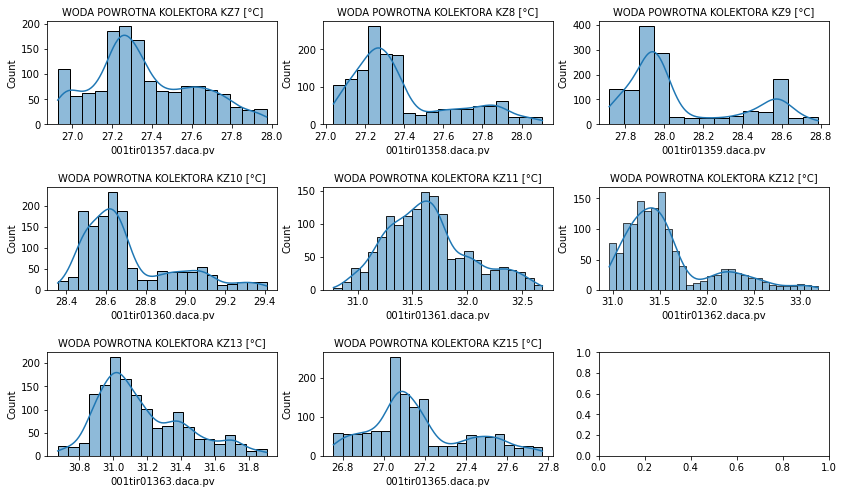

In [7]:
plot_histograms(TIR)

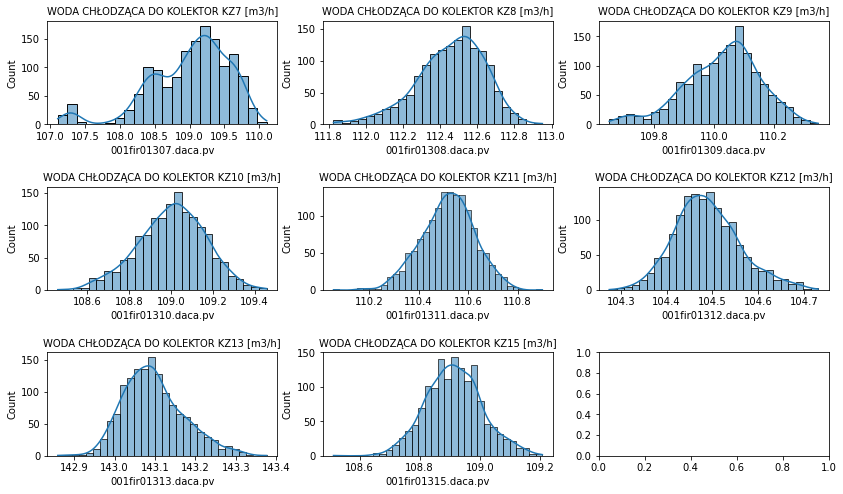

In [8]:
plot_histograms(FIR)

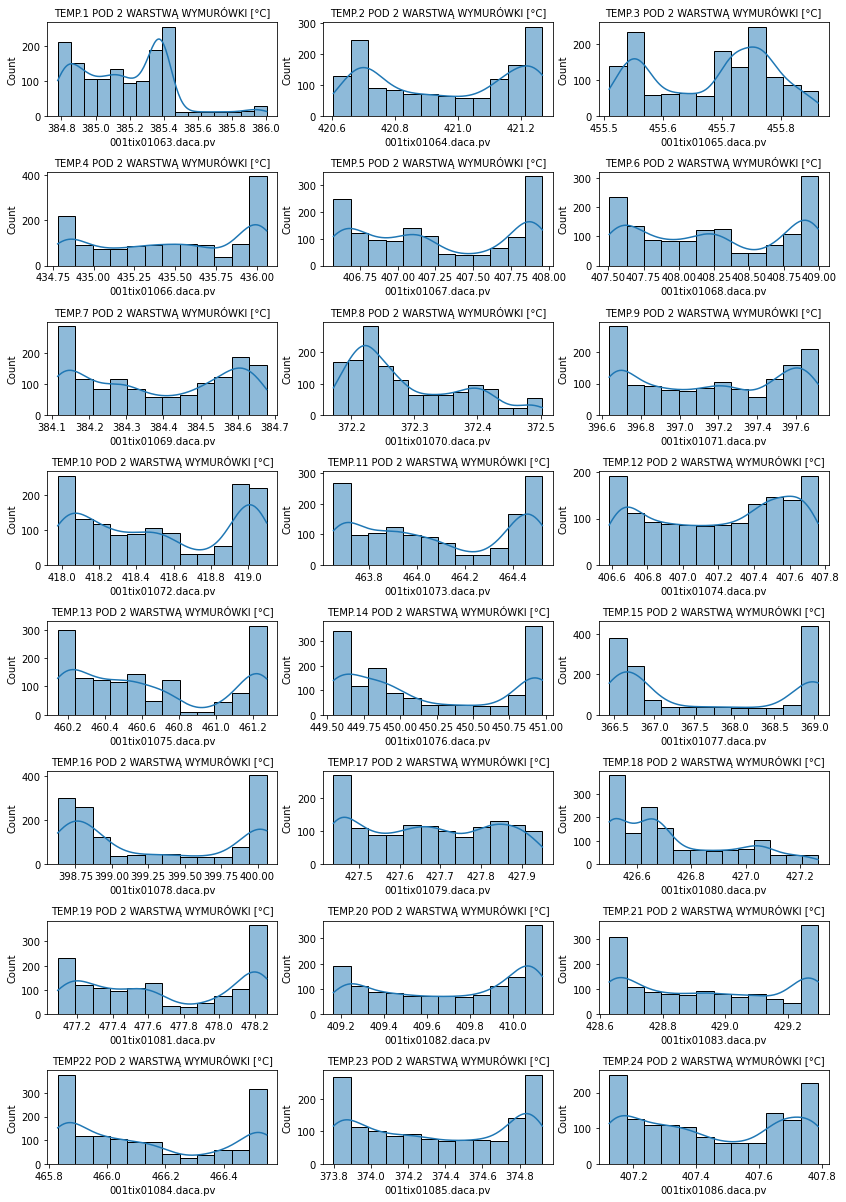

In [9]:
plot_histograms(TIX1)

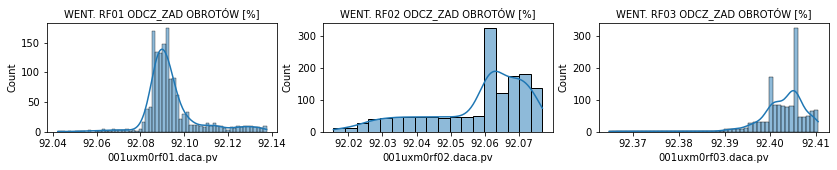

In [10]:
plot_histograms(UXM)

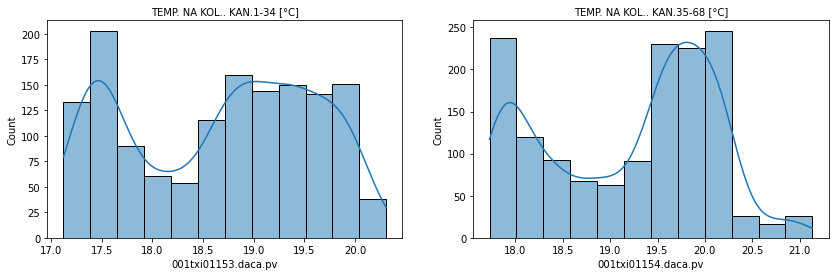

In [11]:
plot_histograms(TXI)

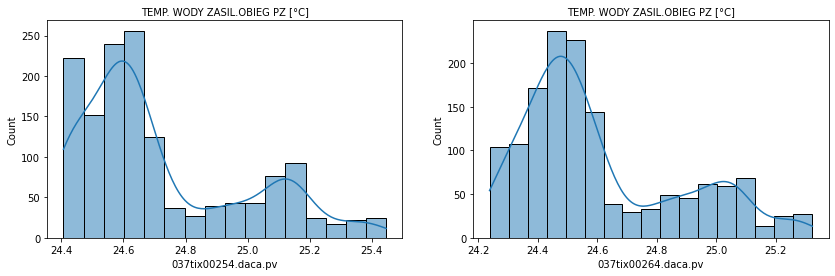

In [12]:
plot_histograms(TIX37)

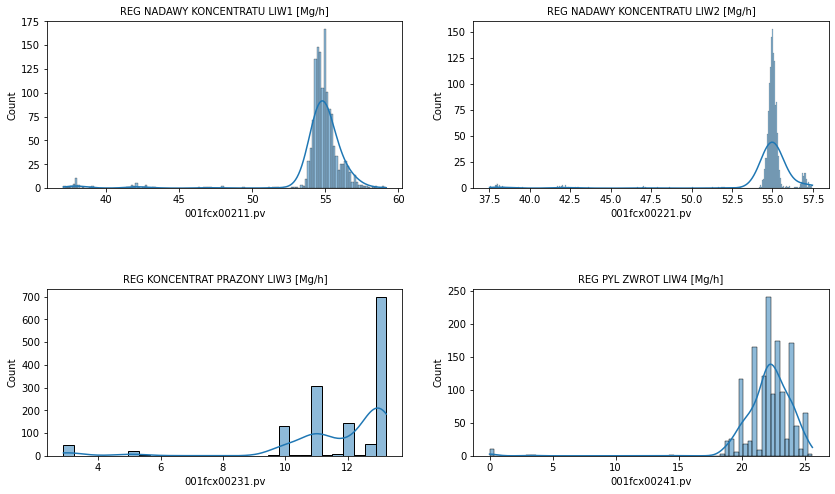

In [13]:
plot_histograms(FCX, ncols=2)

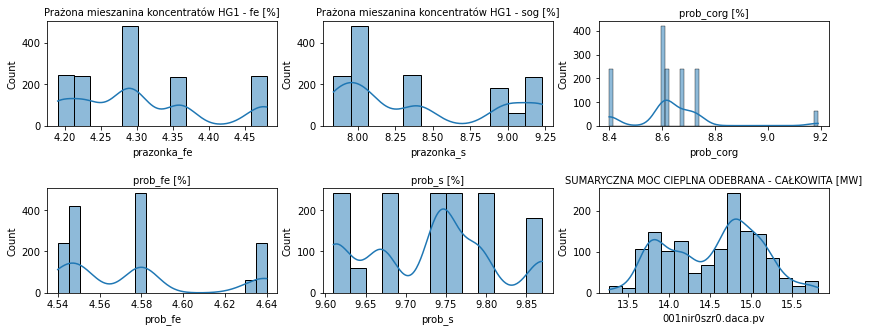

In [14]:
plot_histograms(np.append(PR, NIR))

### Correlations

In [15]:
def corr_plots(*dfs, titles=None, ncols=2, size=14):
    n = len(dfs)
    if n<ncols:
        ncols=n
        nrows=1
    else:
        nrows = int(np.ceil(n/ncols))     
    
    f, axes = plt.subplots(figsize=(size, (size*nrows)//ncols), nrows=nrows, ncols=ncols, squeeze=False)
    plt.subplots_adjust(wspace=0.4, hspace=0.2)
    
    for df, ax, i in zip(dfs, axes.flatten(), range(n)):
        corr = df.corr()
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        sns.heatmap(corr, cmap=cmap, center=0,
                square=True, linewidths=.5, ax=ax, annot=(len(df.columns)*ncols<25))
        if titles:
            ax.set_title(titles[i])

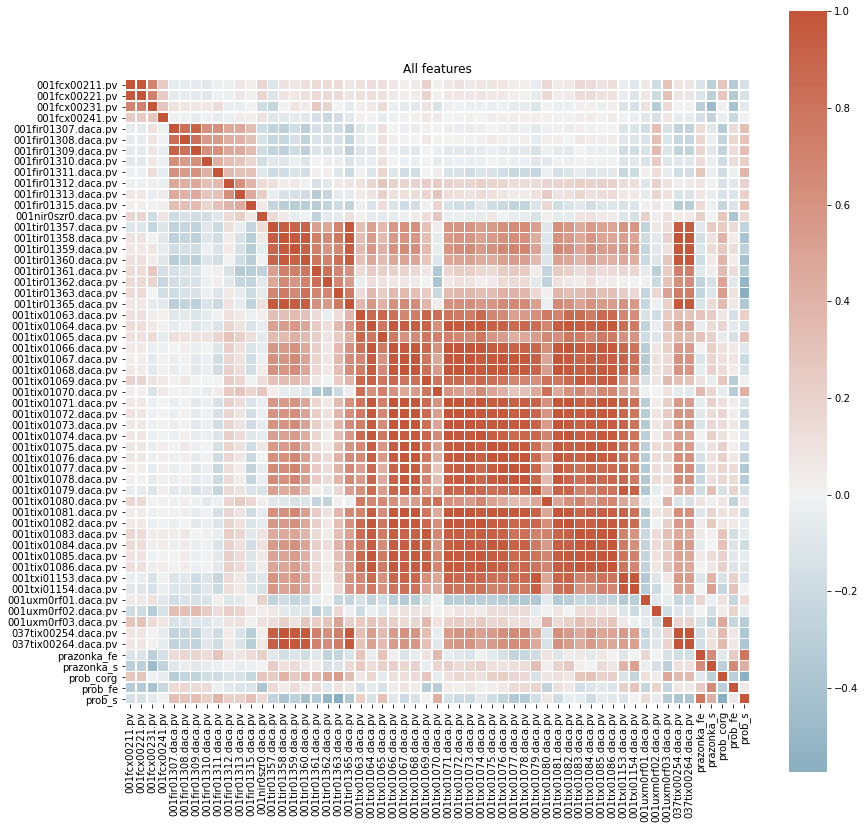

In [16]:
corr_plots(df, titles=["All features"])

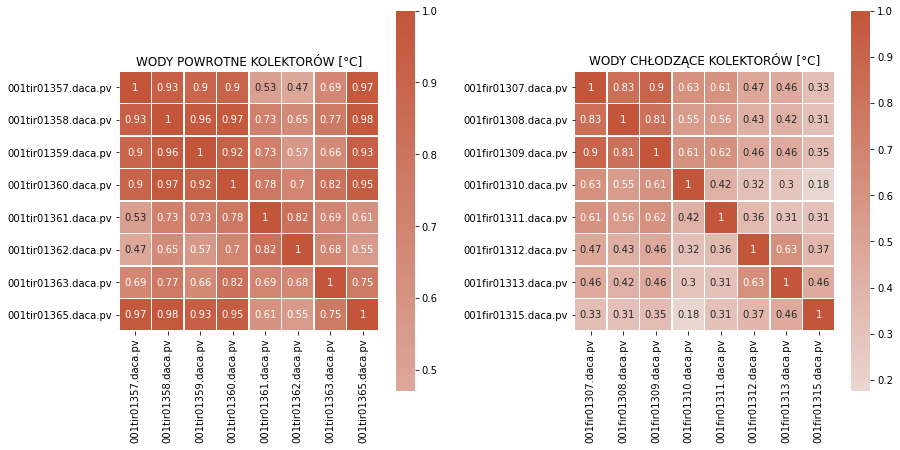

In [17]:
corr_plots(df[TIR], 
           df[FIR], 
           titles=["WODY POWROTNE KOLEKTORÓW [°C]", 
                   "WODY CHŁODZĄCE KOLEKTORÓW [°C]"]
          )

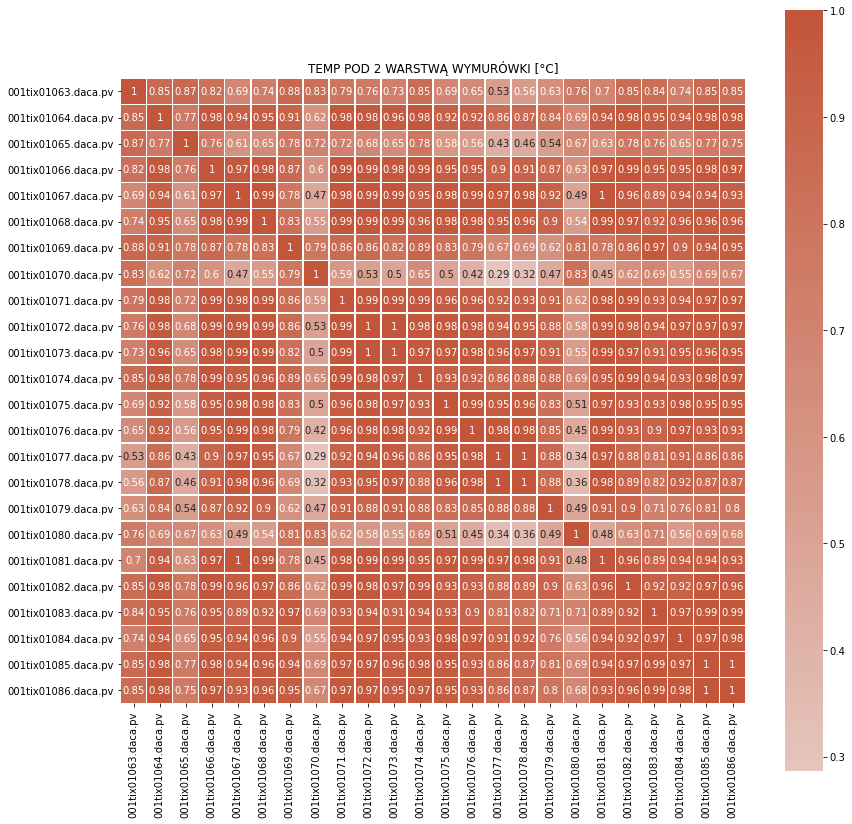

In [18]:
corr_plots(df[TIX1],
           size=14,
           titles=[group_names['TIX1']]
          )

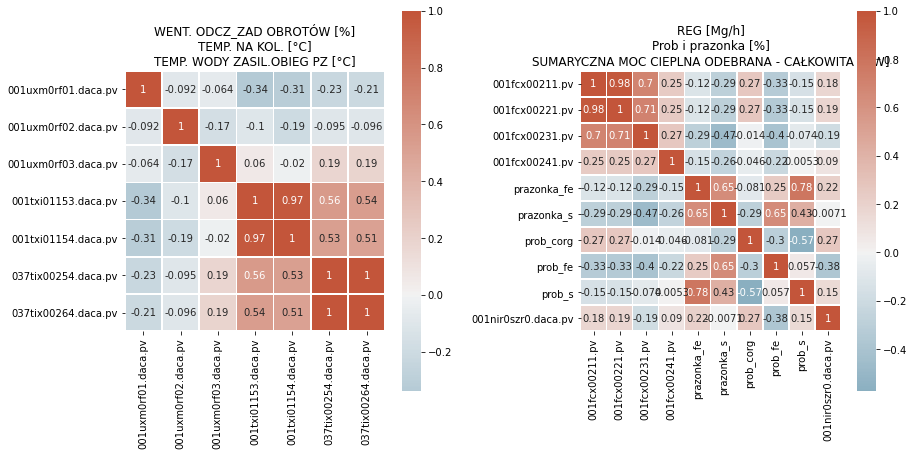

In [19]:
corr_plots(df[np.concatenate([UXM, TXI, TIX37])],
           df[np.concatenate([FCX, PR, NIR])],
          titles=[group_names['UXM'] + '\n' + group_names['TXI'] + '\n' + group_names['TIX37'],
                  group_names['FCX'] + '\n' + group_names['PR'] + '\n' + group_names['NIR']]
                  )

### PCA

In [20]:
scaler = StandardScaler()
data  = scaler.fit_transform(df[df.columns[1:]])

pca = PCA(n_components=3)
components = pca.fit_transform(data)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    height=500
)
fig.show()

### Simple Hourly Aggregates

In [21]:
df_agg = df[:]
df_agg['czas'] = df_agg['czas'].dt.floor("H")
df_agg.groupby('czas')['001fcx00211.pv'].mean()
# tbc

czas
2020-10-01 00:00:00+02:00    54.879452
2020-10-01 01:00:00+02:00    54.780925
2020-10-01 02:00:00+02:00    54.819352
2020-10-01 03:00:00+02:00    54.886083
2020-10-01 04:00:00+02:00    54.906442
2020-10-01 05:00:00+02:00    54.868097
2020-10-01 06:00:00+02:00    54.823493
2020-10-01 07:00:00+02:00    54.890898
2020-10-01 08:00:00+02:00    54.828661
2020-10-01 09:00:00+02:00    54.846556
2020-10-01 10:00:00+02:00    56.558735
2020-10-01 11:00:00+02:00    55.060979
2020-10-01 12:00:00+02:00    42.911862
2020-10-01 13:00:00+02:00    54.879794
2020-10-01 14:00:00+02:00    54.819495
2020-10-01 15:00:00+02:00    54.877676
2020-10-01 16:00:00+02:00    54.823568
2020-10-01 17:00:00+02:00    54.921672
2020-10-01 18:00:00+02:00    54.926667
2020-10-01 19:00:00+02:00    54.885807
2020-10-01 20:00:00+02:00    54.943491
2020-10-01 21:00:00+02:00    54.903878
2020-10-01 22:00:00+02:00    54.884968
2020-10-01 23:00:00+02:00    54.913377
Name: 001fcx00211.pv, dtype: float64

### Features vs temp_zuzel

In [22]:
def plot_histograms_zuzlel(columns, ncols=3):
    n = len(columns)
    if n<ncols:
        ncols=n
        nrows=1
    else:
        nrows = int(np.ceil(n/ncols))
        
    f, axes = plt.subplots(figsize=(14, (8*nrows)//ncols), nrows=nrows, ncols=ncols)
    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    for col, ax in zip(columns, axes.flatten()):
        sns.histplot(df[col], ax=ax, kde=True)
        ax.set_title(feature_desc(col), {'fontsize':10})

In [23]:
def get_corr_zuzel(col_name):
    return round(df[col_name].corr(temp_zuz['temp_zuz']), 2)

In [ ]:
def plot_with_zuzel(columns, ncols=3):
    n = len(columns)
    if n<ncols:
        ncols=n
        nrows=1
    else:
        nrows = int(np.ceil(n/ncols))
        
    f, axes = plt.subplots(figsize=(14, (8*nrows)//ncols), nrows=nrows, ncols=ncols)
    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    for col_name, ax in zip(columns, axes.flatten()):
        corr = get_corr_zuzel(col_name)
        sns.scatterplot(x=temp_zuz['temp_zuz'], y=df[col_name], ax=ax)
        ax.set_title(feature_desc(col_name), {'fontsize':10})
        ax.set(ylabel='', xlabel=("temp_zuz " + str(corr)))

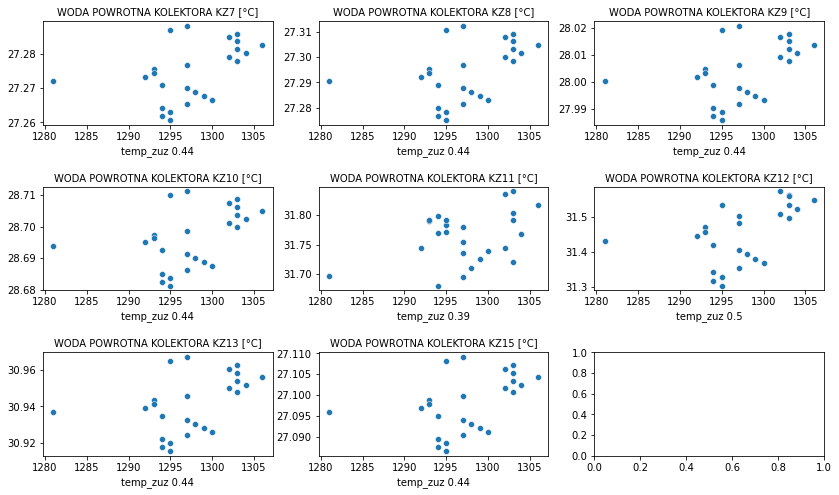

In [25]:
plot_with_zuzel(TIR)

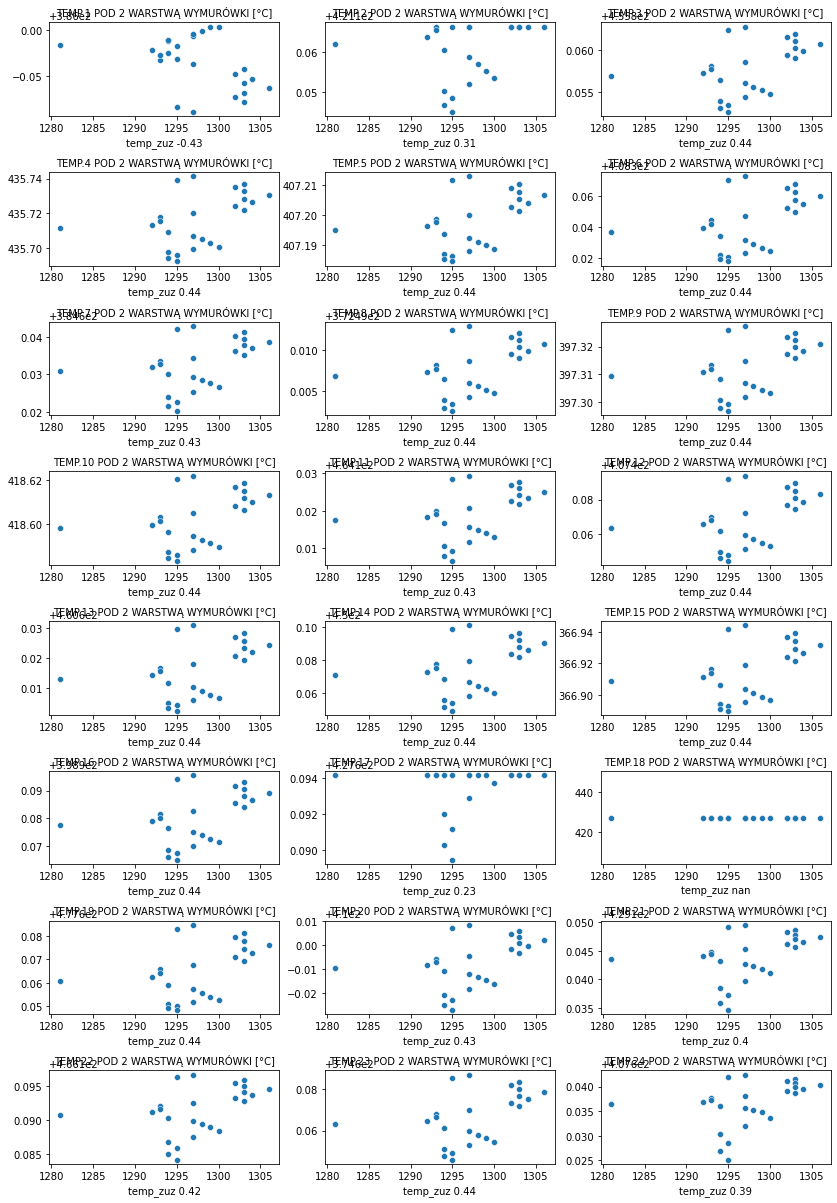

In [26]:
plot_with_zuzel(TIX1)

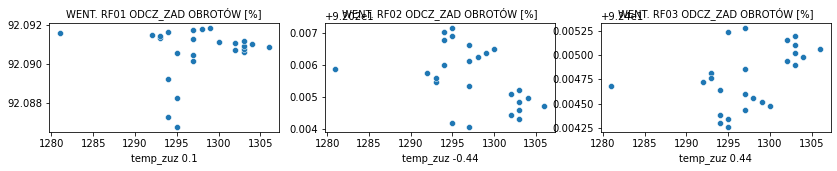

In [27]:
plot_with_zuzel(UXM)

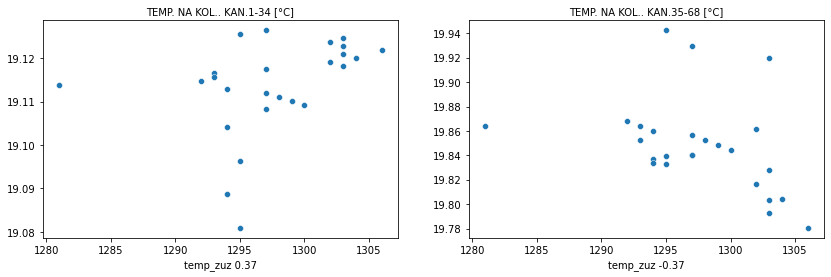

In [28]:
plot_with_zuzel(TXI)

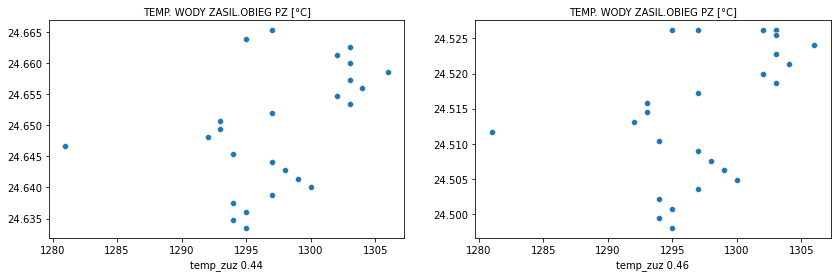

In [29]:
plot_with_zuzel(TIX37)

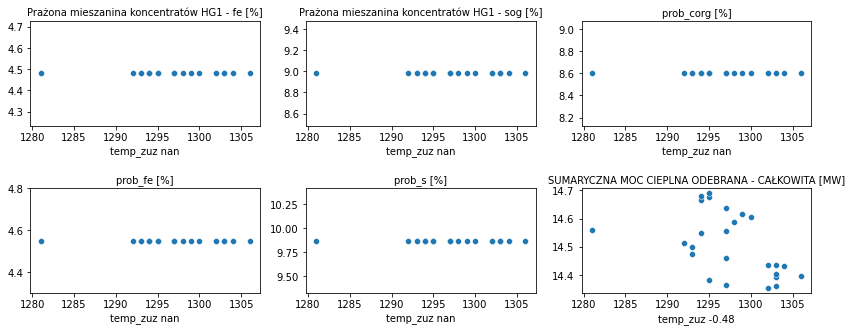

In [30]:
plot_with_zuzel(np.append(PR, NIR))

['prazonka_fe' 'prazonka_s' 'prob_corg' 'prob_fe' 'prob_s'
 '001nir0szr0.daca.pv']


In [32]:
for item in np.append(PR, NIR):
    print(item)

prazonka_fe
prazonka_s
prob_corg
prob_fe
prob_s
001nir0szr0.daca.pv


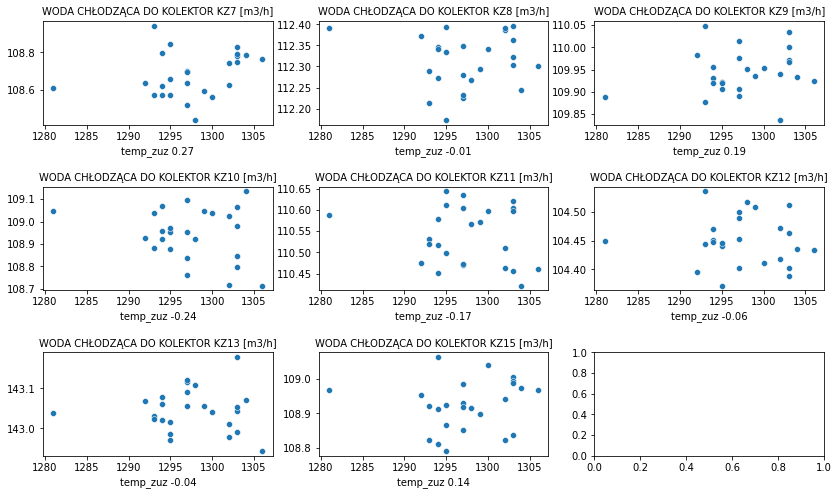

In [34]:
plot_with_zuzel(FIR)

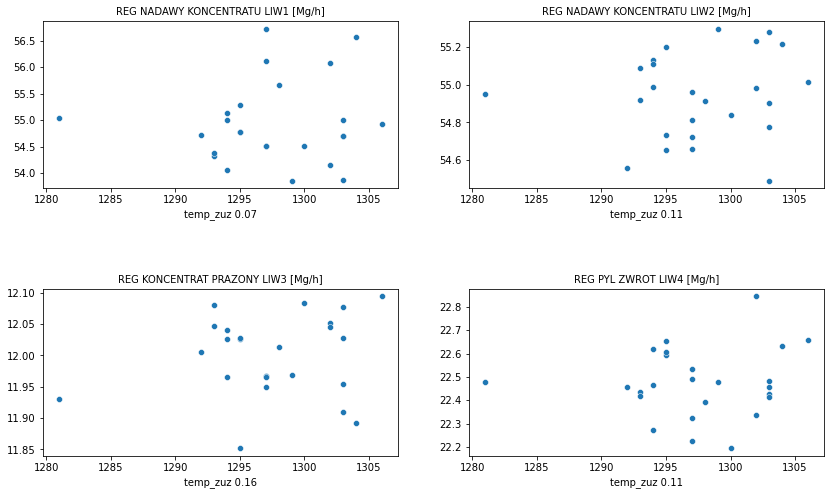

In [35]:
plot_with_zuzel(FCX, ncols=2)